## Table of Contents

1. [Introduction](#1.-introduction)

2. [Imports](#2.-imports)

3. [Daily Return Preparation](#3.-daily-return-preparation)

   3.1 [Load Input CSV files](#3.1-load-input-csv-files)

   3.2 [Clean & Standardize Price Data](#3.2-clean-&-standardize-price-data)

   3.3 [Compute Daily Returns $R_i$, $log(R_i)$, $R_m$, $log(R_m)$, and $R_f$](#3.3-compute-daily-returns-r_i-logr_i-r_m-logr_m-and-r_f)

   3.4 [Align and Merge $R_i$](#3.4-align-and-merge-r_i)

   3.5 [Save Outputs](#3.5-save-outputs)

4. [Portfolio Construction](#4.-portfolio-construction)

   4.1 [Construct Equal-Weighted Portfolio](#4.1-construct-equal-weighted-portfolio)

   4.2 [Construct Optimal Portfolio (Tangency Portfolio)](#4.2-construct-optimal-portfolio-(tangency-portfolio))

5. [Hypothesis Tests](#5.-hypothesis-tests)

   5.1 [Align Series for Hypothesis Tests](#5.1-align-series-for-hypothesis-tests)

   5.2 [Conduct Two-sided F-test for Portfolios Variances](#5.2-conduct-two-sided-f-test-for-portfolios-variances)

6. [Excess Returns for Regression Analysis](#6.-excess-returns-for-regression-analysis)

7. [Market Model Regressions](#7.-market-model-regressions)
   
   7.1 [Regress Excess Stock Returns ~ Excess Market Returns](#7.1-regress-excess-stock-returns-~-excess-market-returns)

   7.2 [7.2 Save Anova Results as DataFrame](#7.2-save-anova-results-as-dataframe)

   7.3 [7.3 Save Regression Results as CSV](#7.3-save-regression-results-as-csv)

8. [$\beta_1 = 1$ Hypothesis Tests](#8.-beta_1-=-1-hypothesis-tests)
   
   8.1 [Compute Rejection Region](#8.1-compute-rejection-region)

   8.2 [Compute t-statistic with $\beta_1=1$, p-value, CI, Decision](#8.2-compute-t-statistic-with-beta_1=1-p-value-ci-decision)

   8.3 [Save $\beta_1$ Hypothesis Test Summary as CSV](#8.3-save-beta_1-hypothesis-test-summary-as-csv)

9. [Model Adequacy](#9.-model-adequacy)

   9.1 [Test Normality of Residuals (Visual Check)](#9.1-test-normality-of-residuals-(visual-check))
   
   9.2 [Test Normality of Residuals (Jarque-Bera)](#9.2-test-normality-of-residuals-(jarque-bera))

   9.3 [Test Heteroskedasticity (Breusch-Pagan)](#9.3-test-heteroskedasticity-(breusch-pagan))

   9.4 [Test Autocorrelation (Durbin-Watson)](#9.4-test-autocorrelation-(durbin-watson))
   
   9.5 [Test Autocorrelation (Breusch-Godfrey)](#9.5-test-autocorrelation-(breusch-godfrey))

### 1. Introduction

### 2. Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import f
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from scipy.stats import jarque_bera
from scipy.stats import skew, kurtosis, norm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

### 3. Daily Return Preparation

##### 3.1 Load Input CSV files

In [2]:
# Individual stocks
tickers = ["jpm", "bac", "wfc", "gs", "blk", "pld", "amt", "spg", "avb", "o"]
stock_data = {}

for t in tickers:
    stock_data[t.upper()] = pd.read_csv(f"../data/in/{t}.csv")
    print(t.upper(), stock_data[t.upper()].shape)

# Market index
sp500 = pd.read_csv("../data/in/sp500.csv")
print("\nS&P 500 shape:", sp500.shape)

# Risk-free rate
tbill = pd.read_csv("../data/in/13w_tbill.csv")
print("\nT-bill shape:", tbill.shape)

JPM (1256, 6)
BAC (1256, 6)
WFC (1256, 6)
GS (1256, 6)
BLK (1256, 6)
PLD (1256, 6)
AMT (1256, 6)
SPG (1256, 6)
AVB (1256, 6)
O (1256, 6)

S&P 500 shape: (1255, 6)

T-bill shape: (1256, 6)


##### 3.2 Clean & Standardize Price Data

In [3]:
# Clean individual stock price files
clean_stocks = {}

for t in tickers:
    df = stock_data[t.upper()].copy()

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Clean "Close/Last" (remove any "$" symbols, convert to float)
    df['Close'] = df['Close/Last'].replace('[\\$,]', '', regex=True).astype(float)

    # Keep only Date + Close columns
    df = df[['Date', 'Close']].sort_values('Date')

    clean_stocks[t.upper()] = df

    print(f"Sample cleaned stock ({t.upper()}):")
    print(clean_stocks[t.upper()].head(3))

# Clean S&P 500
sp500_clean = sp500.copy()
sp500_clean['Date'] = pd.to_datetime(sp500_clean['Date'], format='%m/%d/%y')
sp500_clean = sp500_clean[['Date', 'Close']].sort_values('Date')

# Clean 13-week T-bill
tbill_clean = tbill.copy()
tbill_clean['Date'] = pd.to_datetime(tbill_clean['Date'], format='%m/%d/%y')
tbill_clean = tbill_clean[['Date', 'Close']].sort_values('Date')

# Show first 3 rows from each for verification
print("Sample cleaned stock (JPM):")
print(clean_stocks['JPM'].head(3))

print("\nSample cleaned S&P500:")
print(sp500_clean.head(3))

print("\nSample cleaned T-bill:")
print(tbill_clean.head(3))

Sample cleaned stock (JPM):
           Date   Close
1255 2020-10-19   99.80
1254 2020-10-20  100.37
1253 2020-10-21   99.37
Sample cleaned stock (BAC):
           Date  Close
1255 2020-10-19  23.72
1254 2020-10-20  24.14
1253 2020-10-21  24.05
Sample cleaned stock (WFC):
           Date  Close
1255 2020-10-19  22.54
1254 2020-10-20  22.81
1253 2020-10-21  22.70
Sample cleaned stock (GS):
           Date   Close
1255 2020-10-19  205.69
1254 2020-10-20  208.03
1253 2020-10-21  202.91
Sample cleaned stock (BLK):
           Date   Close
1255 2020-10-19  634.89
1254 2020-10-20  645.07
1253 2020-10-21  634.99
Sample cleaned stock (PLD):
           Date   Close
1255 2020-10-19  103.02
1254 2020-10-20  103.53
1253 2020-10-21  102.65
Sample cleaned stock (AMT):
           Date   Close
1255 2020-10-19  239.60
1254 2020-10-20  243.80
1253 2020-10-21  241.74
Sample cleaned stock (SPG):
           Date  Close
1255 2020-10-19  63.91
1254 2020-10-20  64.46
1253 2020-10-21  64.21
Sample cleaned stock 

##### 3.3 Compute Daily Returns $R_i$, $log(R_i)$, $R_m$, $log(R_m)$, and $R_f$

In [4]:
# Compute daily returns (Ret) and log returns (LogRet) for each stock
stock_returns = {}

for t in tickers:
    df = clean_stocks[t.upper()].copy()

    # Arithmetic return
    df['Ret'] = df['Close'] / df['Close'].shift(1) - 1

    # Log return
    df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))

    df = df.dropna()
    stock_returns[t.upper()] = df[['Date', 'Ret', 'LogRet']]
    
    print(f"Sample Returns (Ri = {t.upper()}):")
    print(stock_returns[t.upper()].head(3))

# Compute market returns and log returns
sp500_ret = sp500_clean.copy()
sp500_ret['Market_Ret'] = sp500_ret['Close'] / sp500_ret['Close'].shift(1) - 1
sp500_ret['Market_LogRet'] = np.log(sp500_ret['Close'] / sp500_ret['Close'].shift(1))
sp500_ret = sp500_ret.dropna()
sp500_ret = sp500_ret[['Date', 'Market_Ret', 'Market_LogRet']]

print(f"Sample Market Returns (Rm):")
print(sp500_ret.head(3))

# Convert T-bill annualized yield to daily rate (RF)
tbill_daily = tbill_clean.copy()
tbill_daily['RF_Daily'] = (1 + tbill_daily['Close']/100)**(1/252) - 1
tbill_daily = tbill_daily[['Date', 'RF_Daily']]

print(f"Sample Daily Risk-Free Rate (Rf):")
print(tbill_daily.head(3))

Sample Returns (Ri = JPM):
           Date       Ret    LogRet
1254 2020-10-20  0.005711  0.005695
1253 2020-10-21 -0.009963 -0.010013
1252 2020-10-22  0.035323  0.034713
Sample Returns (Ri = BAC):
           Date       Ret    LogRet
1254 2020-10-20  0.017707  0.017552
1253 2020-10-21 -0.003728 -0.003735
1252 2020-10-22  0.034096  0.033527
Sample Returns (Ri = WFC):
           Date       Ret    LogRet
1254 2020-10-20  0.011979  0.011908
1253 2020-10-21 -0.004822 -0.004834
1252 2020-10-22  0.024229  0.023940
Sample Returns (Ri = GS):
           Date       Ret    LogRet
1254 2020-10-20  0.011376  0.011312
1253 2020-10-21 -0.024612 -0.024920
1252 2020-10-22  0.012271  0.012197
Sample Returns (Ri = BLK):
           Date       Ret    LogRet
1254 2020-10-20  0.016034  0.015907
1253 2020-10-21 -0.015626 -0.015750
1252 2020-10-22  0.000299  0.000299
Sample Returns (Ri = PLD):
           Date       Ret    LogRet
1254 2020-10-20  0.004950  0.004938
1253 2020-10-21 -0.008500 -0.008536
1252 2020-1

##### 3.4 Align and Merge $R_i$

In [5]:
# Merge all stock returns into wide format

merged_stocks = None

for t in tickers:
    df = stock_returns[t.upper()].copy()
    df = df.rename(columns={
        'Ret': f"{t.upper()}_Ret",
        'LogRet': f"{t.upper()}_LogRet"
    })

    if merged_stocks is None:
        merged_stocks = df
    else:
        merged_stocks = pd.merge(merged_stocks, df, on='Date', how='inner')

print("Merged Daily Stock Returns (wide format):")
print(merged_stocks.head(3))

Merged Daily Stock Returns (wide format):
        Date   JPM_Ret  JPM_LogRet   BAC_Ret  BAC_LogRet   WFC_Ret  \
0 2020-10-20  0.005711    0.005695  0.017707    0.017552  0.011979   
1 2020-10-21 -0.009963   -0.010013 -0.003728   -0.003735 -0.004822   
2 2020-10-22  0.035323    0.034713  0.034096    0.033527  0.024229   

   WFC_LogRet    GS_Ret  GS_LogRet   BLK_Ret  ...   PLD_Ret  PLD_LogRet  \
0    0.011908  0.011376   0.011312  0.016034  ...  0.004950    0.004938   
1   -0.004834 -0.024612  -0.024920 -0.015626  ... -0.008500   -0.008536   
2    0.023940  0.012271   0.012197  0.000299  ...  0.001461    0.001460   

    AMT_Ret  AMT_LogRet   SPG_Ret  SPG_LogRet   AVB_Ret  AVB_LogRet     O_Ret  \
0  0.017529    0.017377  0.008606    0.008569  0.000963    0.000962  0.005957   
1 -0.008450   -0.008485 -0.003878   -0.003886  0.002886    0.002881  0.009814   
2 -0.024696   -0.025006  0.033328    0.032785  0.003494    0.003488  0.006870   

   O_LogRet  
0  0.005940  
1  0.009766  
2  0.0068

##### 3.5 Save Outputs

In [6]:
# Save wide stock returns
merged_stocks.to_csv("../data/out/3_daily_stock_returns.csv", index=False)
print("Saved: 3_daily_stock_returns.csv")

# Save market returns
daily_market_returns = sp500_ret.copy()
daily_market_returns.to_csv("../data/out/3_daily_market_returns.csv", index=False)
print("Saved: 3_daily_market_returns.csv")

# Save risk-free returns
daily_riskfree_returns = tbill_daily.copy()
daily_riskfree_returns.to_csv("../data/out/3_daily_riskfree_returns.csv", index=False)
print("Saved: 3_daily_riskfree_returns.csv")

Saved: 3_daily_stock_returns.csv
Saved: 3_daily_market_returns.csv
Saved: 3_daily_riskfree_returns.csv


### 4. Portfolio Construction

##### 4.1 Construct Equal-Weighted Portfolio

In [7]:
# 4.1.1 Extract Daily Log Returns
logret_cols = [c for c in merged_stocks.columns if c.endswith("_LogRet")]
logret_df = merged_stocks[["Date"] + logret_cols].copy()

# 4.1.2 Compute Equal-Weighted Log Return Series
n_stocks = len(logret_cols)
ew_weights = np.full(n_stocks, 1/n_stocks)

logret_matrix = logret_df[logret_cols].values
logret_df["EW_LogRet"] = logret_matrix.dot(ew_weights)

# 4.1.3 Save Equal-Weighted Portfolio Output
ew_output = logret_df[["Date", "EW_LogRet"]].copy()
ew_output.to_csv("../data/out/4_portfolio_equal_weight_logreturns.csv", index=False)
print("Saved: 4_portfolio_equal_weight_logreturns.csv")

Saved: 4_portfolio_equal_weight_logreturns.csv


##### 4.2 Construct Optimal Portfolio (Tangency Portfolio)

In [8]:
# 4.2.1 Extract Daily Log Returns
logret_cols = [c for c in merged_stocks.columns if c.endswith("_LogRet")]
logret_df = merged_stocks[["Date"] + logret_cols].copy()

# Drop Date for matrix calculations
R = logret_df[logret_cols].values

# 4.2.2 Compute μ (mean vector) and Σ (covariance matrix)
mu = R.mean(axis=0)
Sigma = np.cov(R, rowvar=False)

# 4.2.3 Align Risk-Free Rate (RF_Daily)
rf_df = daily_riskfree_returns.copy()
rf_df = rf_df.sort_values("Date")

# Inner join to ensure perfect alignment with stock return dates
aligned = pd.merge(logret_df[["Date"]], rf_df, on="Date", how="inner")
# rf = aligned["RF_Daily"].values

# 4.2.4 Define Negative Sharpe Ratio Objective (Project 1 pattern)
def neg_sharpe(weights, mu, Sigma, rf_daily):
    port_ret = np.dot(weights, mu)
    port_var = np.dot(weights.T, np.dot(Sigma, weights))
    port_vol = np.sqrt(port_var)
    return -(port_ret - rf_daily) / port_vol

# 4.2.5 Set Constraints and Bounds, Then Solve with SLSQP
n = len(mu)
initial_w = np.full(n, 1/n)
bounds = [(0, 1)] * n
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

rf_daily = aligned["RF_Daily"].mean()

opt_result = minimize(
    neg_sharpe,
    initial_w,
    args=(mu, Sigma, rf_daily),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

optimal_w = opt_result.x

# 4.2.6 Save Optimal Weights
w_df = pd.DataFrame({
    "Ticker": logret_cols,
    "Weight": optimal_w
})
print(f"Weights for optimal portfolio: \n{w_df.sort_values(by='Weight', ascending=False).round(4)}")
w_df.to_csv("../data/out/4_optimal_weights_daily.csv", index=False)
print("Saved: 4_optimal_weights_daily.csv")

# 4.2.7 Construct Optimal-Weighted Portfolio Log Return Series
logret_matrix = logret_df[logret_cols].values
logret_df["OPT_LogRet"] = logret_matrix.dot(optimal_w)

# 4.2.8 Save Optimal Portfolio Output
opt_output = logret_df[["Date", "OPT_LogRet"]].copy()
opt_output.to_csv("../data/out/4_portfolio_optimal_weight_logreturns.csv", index=False)
print("Saved: 4_portfolio_optimal_weight_logreturns.csv")

Weights for optimal portfolio: 
       Ticker  Weight
3   GS_LogRet  0.5764
0  JPM_LogRet  0.1796
2  WFC_LogRet  0.1600
7  SPG_LogRet  0.0840
1  BAC_LogRet  0.0000
9    O_LogRet  0.0000
5  PLD_LogRet  0.0000
4  BLK_LogRet  0.0000
6  AMT_LogRet  0.0000
8  AVB_LogRet  0.0000
Saved: 4_optimal_weights_daily.csv
Saved: 4_portfolio_optimal_weight_logreturns.csv


### 5. Hypothesis Tests

##### 5.1 Align Series for Hypothesis Tests

In [9]:
# 5.1.1: Align by Date (inner join)
df = ew_output.merge(opt_output, on="Date", how="inner")

# Extract aligned numpy vectors
ew = df["EW_LogRet"].values
opt = df["OPT_LogRet"].values

print("Aligned shape:", df.shape)
print("EW observations lost:", len(ew_output) - len(df))
print("OPT observations lost:", len(opt_output) - len(df))

Aligned shape: (1255, 3)
EW observations lost: 0
OPT observations lost: 0


##### 5.2 Conduct two-sided F-test for Portfolios Variances

$H_0: \sigma_{EW}^2 = \sigma_{Opt}^2$<br>
$H_1: \sigma_{EW}^2 \neq \sigma_{Opt}^2$

In [10]:
# Sample variances
sew_sq = np.var(ew, ddof=1)     # EW portfolio variance
sopt_sq = np.var(opt, ddof=1)    # OPT portfolio variance

# F statistic (larger variance on top to keep F ≥ 1)
if sew_sq >= sopt_sq:
    F_stat = sew_sq / sopt_sq
    df1 = len(ew) - 1
    df2 = len(opt) - 1
else:
    F_stat = sopt_sq / sew_sq
    df1 = len(opt) - 1
    df2 = len(ew) - 1

# Two-sided p-value
p_value = 2 * min(
    f.cdf(F_stat, df1, df2),
    1 - f.cdf(F_stat, df1, df2)
)

print("F-statistic:", F_stat)
print("p-value:", p_value)

# Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis: Variances differ.")
else:
    print("Fail to reject the null hypothesis: Variances are statistically equal.")

F-statistic: 1.6769232302440173
p-value: 2.220446049250313e-16
Reject the null hypothesis: Variances differ.


In [11]:
# Additional F-Test Analysis

# One-sided p-values
p_right = 1 - f.cdf(F_stat, df1, df2)   # H1: σ_EW² > σ_OPT²
p_left  = f.cdf(F_stat, df1, df2)       # H1: σ_EW² < σ_OPT²

print("Right-tail p-value (EW > OPT):", p_right)
print("Left-tail p-value  (EW < OPT):", p_left)

# 95% Confidence Interval for the Variance Ratio
alpha = 0.05

F_lower = f.ppf(alpha/2, df1, df2)
F_upper = f.ppf(1 - alpha/2, df1, df2)

CI_lower = F_stat / F_upper
CI_upper = F_stat / F_lower

print("\n95% Confidence Interval for variance ratio (σ_EW² / σ_OPT²):")
print("Lower bound:", CI_lower)
print("Upper bound:", CI_upper)


Right-tail p-value (EW > OPT): 1.1102230246251565e-16
Left-tail p-value  (EW < OPT): 0.9999999999999999

95% Confidence Interval for variance ratio (σ_EW² / σ_OPT²):
Lower bound: 1.501125299430942
Upper bound: 1.8733089910602738


##### 5.3 Conduct Welch Two-Sample t-Test for Portfolio Means

$H_0: \mu_{EW} = \mu_{Opt}$<br>
$H_1: \mu_{EW} \neq \mu_{Opt}$

In [12]:
# Welch t-test (unequal variances)

t_stat, p_value = ttest_ind(ew, opt, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

# Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis: Means differ.")
else:
    print("Fail to reject the null hypothesis: Means are statistically equal.")

t-statistic: -0.8443775792667289
p-value: 0.39854413075045547
Fail to reject the null hypothesis: Means are statistically equal.


### 6. Excess Returns for Regression Analysis

In [13]:
# 6.1 Align by Date (inner join across stocks, market, and risk-free)
daily_riskfree_returns['RF_Daily_LogRet'] = np.log(1 + daily_riskfree_returns['RF_Daily'])
aligned = (
    merged_stocks
        .merge(daily_market_returns, on="Date", how="inner")
        .merge(daily_riskfree_returns, on="Date", how="inner")
)
aligned.columns

Index(['Date', 'JPM_Ret', 'JPM_LogRet', 'BAC_Ret', 'BAC_LogRet', 'WFC_Ret',
       'WFC_LogRet', 'GS_Ret', 'GS_LogRet', 'BLK_Ret', 'BLK_LogRet', 'PLD_Ret',
       'PLD_LogRet', 'AMT_Ret', 'AMT_LogRet', 'SPG_Ret', 'SPG_LogRet',
       'AVB_Ret', 'AVB_LogRet', 'O_Ret', 'O_LogRet', 'Market_Ret',
       'Market_LogRet', 'RF_Daily', 'RF_Daily_LogRet'],
      dtype='object')

In [14]:
# 6.2 Compute Excess Returns for each stock
excess_returns = aligned[["Date"]].copy()

for col in merged_stocks.columns:
    if col.endswith("_LogRet") and not col.startswith("Market"):
        ticker = col.replace("_LogRet", "")
        excess_returns[f"{ticker}_Excess"] = aligned[col] - aligned["RF_Daily_LogRet"]

# 6.3 Compute Market Excess Return
excess_returns["Market_Excess"] = aligned["Market_LogRet"] - aligned["RF_Daily_LogRet"]

print("Aligned shape:", excess_returns.shape)
print("Daily stock returns observations lost:", len(merged_stocks) - len(excess_returns))
print("Market returns observations lost:", len(daily_market_returns) - len(excess_returns))
print("Risk-free returns observations lost:", len(daily_riskfree_returns) - len(excess_returns))
print(f"\n\nSample Excess Returns:\n\n {excess_returns.head(3)}")

Aligned shape: (1250, 12)
Daily stock returns observations lost: 5
Market returns observations lost: 4
Risk-free returns observations lost: 6


Sample Excess Returns:

         Date  JPM_Excess  BAC_Excess  WFC_Excess  GS_Excess  BLK_Excess  \
0 2020-10-27   -0.019050   -0.028524   -0.039542  -0.027524   -0.012391   
1 2020-10-28   -0.028494   -0.016065   -0.029773  -0.030671   -0.022749   
2 2020-10-29    0.006501    0.002975   -0.001894   0.000892    0.002690   

   PLD_Excess  AMT_Excess  SPG_Excess  AVB_Excess  O_Excess  Market_Excess  
0   -0.013330   -0.004060   -0.042644   -0.024717 -0.018559      -0.003034  
1   -0.016582   -0.025869   -0.019884   -0.052622 -0.015793      -0.035929  
2    0.027010    0.006580    0.042687    0.025441  0.012203       0.011873  


### 7. Market Model Regressions

$R_i−R_f=β_0+β_1 (R_m−R_f)+𝜀_i$

##### 7.1 Regress Excess Stock Returns ~ Excess Market Returns

In [15]:
def run_market_model(df, y_col):
    formula = f"{y_col} ~ Market_Excess"
    model = smf.ols(formula=formula, data=df).fit()
    anova_table = anova_lm(model)
    residuals = model.resid
    return model, anova_table, residuals

In [16]:
tickers = [
    "JPM", "BAC", "WFC", "GS", "BLK",
    "PLD", "AMT", "SPG", "AVB", "O"
]

results_dict = {}
anova_tables = {}
residuals_df = pd.DataFrame({"Date": excess_returns["Date"]})

summary = []

for t in tickers:
    y_col = f"{t}_Excess"

    model, anova_table, residuals = run_market_model(excess_returns, y_col)

    results_dict[t] = model
    anova_tables[t] = anova_table
    residuals_df[f"residual_{t}"] = residuals

    summary.append({
        "ticker": t,
        "R2": model.rsquared,
        "beta0_hat": model.params["Intercept"],
        "se_beta0": model.bse["Intercept"],
        "t_beta0": model.tvalues["Intercept"],
        "p_beta0": model.pvalues["Intercept"],
        "beta1_hat": model.params["Market_Excess"],
        "se_beta1": model.bse["Market_Excess"],
        "t_beta1": model.tvalues["Market_Excess"],
        "p_beta1": model.pvalues["Market_Excess"],
        "ci_lower_beta1": model.conf_int().loc["Market_Excess", 0],
        "ci_upper_beta1": model.conf_int().loc["Market_Excess", 1],
        "anova_F": anova_table.loc["Market_Excess", "F"],
        "anova_p": anova_table.loc["Market_Excess", "PR(>F)"],
    })

    print(f"\n\nRegression Results for {t}")
    print(f"\n{model.summary()}\n")
    print(f"{'='*90}\n{model.summary2().tables[1]}\n{'='*90}\n")

residuals_df = residuals_df.sort_values("Date")
regression = pd.DataFrame(summary)



Regression Results for JPM

                            OLS Regression Results                            
Dep. Variable:             JPM_Excess   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     758.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          8.14e-131
Time:                        21:56:51   Log-Likelihood:                 3702.5
No. Observations:                1250   AIC:                            -7401.
Df Residuals:                    1248   BIC:                            -7391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       

##### 7.2 Save Anova Results as DataFrame

In [17]:
# Convert anova_tables dict into a long, tidy ANOVA summary DataFrame
anova_summary_rows = []

for ticker, table in anova_tables.items():
    # Extract only the Market_Excess row
    row = table.loc["Market_Excess"]

    anova_summary_rows.append({
        "ticker": ticker,
        "degrees_of_freedom": int(row["df"]),
        "sum_sq": row["sum_sq"],
        "mean_sq": row["sum_sq"] / int(row["df"]),
        "F": row["F"],
        "p_value": row["PR(>F)"],
    })

anova_summary = pd.DataFrame(anova_summary_rows)

##### 7.3 Save Regression Results as CSV

In [18]:
# Merge regression_summary and anova_summary on ticker
regression_summary = regression.merge(
    anova_summary,
    on="ticker",
    how="inner",
    suffixes=("", "_anova")   # in case needed
)
regression_summary = regression_summary.drop(["F", "p_value"], axis=1)
display(regression_summary)
regression_summary.to_csv("../data/out/7_market_model_regression_summary.csv", index=False)
print("Saved: 7_market_model_regression_summary.csv")

,ticker,R2,beta0_hat,se_beta0,t_beta0,p_beta0,beta1_hat,se_beta1,t_beta1,p_beta1,ci_lower_beta1,ci_upper_beta1,anova_F,anova_p,degrees_of_freedom,sum_sq,mean_sq
0,JPM,0.377952,0.000364,0.000354,1.025685,0.305239,0.906341,0.032914,27.536792,8.141826e-131,0.841769,0.970914,758.274920,8.141826e-131,1,0.118920,0.118920
1,BAC,0.362153,0.000055,0.000401,0.137567,0.890605,0.991167,0.037235,26.619226,5.207625e-124,0.918117,1.064217,708.583196,5.207625e-124,1,0.142222,0.142222
2,WFC,0.309228,0.000488,0.000470,1.039126,0.298947,1.031688,0.043648,23.636302,2.252292e-102,0.946055,1.117320,558.674789,2.252292e-102,1,0.154088,0.154088
3,GS,0.457649,0.000478,0.000362,1.322161,0.186357,1.089515,0.033574,32.451369,5.178990e-168,1.023648,1.155382,1053.091321,5.178990e-168,1,0.171846,0.171846
4,BLK,0.611891,-0.000124,0.000292,-0.424507,0.671269,1.203051,0.027122,44.357512,9.279622e-259,1.149842,1.256260,1967.588838,9.279622e-259,1,0.209527,0.209527
5,PLD,0.355558,-0.000350,0.000392,-0.894028,0.371479,0.954789,0.036386,26.240418,3.223396e-121,0.883404,1.026174,688.559524,3.223396e-121,1,0.131973,0.131973
6,AMT,0.125278,-0.000517,0.000435,-1.190067,0.234247,0.539398,0.040346,13.369311,3.384001e-38,0.460245,0.618552,178.738464,3.384001e-38,1,0.042120,0.042120
7,SPG,0.330565,0.000249,0.000458,0.543164,0.587114,1.055777,0.042530,24.824550,6.847344e-111,0.972340,1.139214,616.258290,6.847344e-111,1,0.161367,0.161367
8,AVB,0.285030,-0.000209,0.000348,-0.599466,0.548971,0.720568,0.032305,22.305317,5.024910e-93,0.657190,0.783946,497.527169,5.024910e-93,1,0.075166,0.075166
9,O,0.168145,-0.000301,0.000321,-0.937472,0.348697,0.473589,0.029818,15.882741,7.061975e-52,0.415090,0.532087,252.261449,7.061975e-52,1,0.032469,0.032469


Saved: 7_market_model_regression_summary.csv


### 8. $\beta_1 = 1$ Hypothesis Tests

##### 8.1 Compute Rejection Region

In [19]:
# Compute critical value for two-sided test, alpha = 0.05
k = 1
df = len(excess_returns) - k - 1
crit = stats.t.ppf(1 - 0.025, df)

print(f"Critical value for two-sided test (alpha=0.05, df={df}): ±{crit}")
print(f"Rejection region: t < -{crit} or t > {crit}\n")

Critical value for two-sided test (alpha=0.05, df=1248): ±1.9618666564067104
Rejection region: t < -1.9618666564067104 or t > 1.9618666564067104



##### 8.2 Compute t-statistic with $\beta_1=1$, p-value, CI, Decision

$H_0: \beta_1 = 1$<br>
$H_1: \beta_1 \neq 1$

In [20]:
# Compute t-statistic, p-value, CI, and decision for H0: beta1 = 1

beta1_hat = regression_summary["beta1_hat"]
se = regression_summary["se_beta1"]

regression_summary["t_stat_vs1"] = (beta1_hat - 1) / se
regression_summary["p_value_vs1"] = 2 * (1 - stats.t.cdf(abs(regression_summary["t_stat_vs1"]), df))

regression_summary["critical_value"] = crit
regression_summary["ci_lower_vs1"] = beta1_hat - crit * se
regression_summary["ci_upper_vs1"] = beta1_hat + crit * se

regression_summary["reject_null_hypothesis"] = (
    abs(regression_summary["t_stat_vs1"]) > crit
).map({True: "Yes", False: "No"})


##### 8.3. Save $\beta_1$ Hypothesis Test Summary as CSV

In [21]:
# Final output for report
beta1_test_summary = regression_summary[[
    "ticker",
    "beta1_hat",
    "se_beta1",
    "t_stat_vs1",
    "p_value_vs1",
    "critical_value",
    "ci_lower_vs1",
    "ci_upper_vs1",
    "reject_null_hypothesis"
]].copy()

display(beta1_test_summary)
beta1_test_summary.to_csv("../data/out/8_beta1_hypothesis_test_summary.csv", index=False)
print("\n\nSaved: 8_beta1_hypothesis_test_summary.csv")

,ticker,beta1_hat,se_beta1,t_stat_vs1,p_value_vs1,critical_value,ci_lower_vs1,ci_upper_vs1,reject_null_hypothesis
0,JPM,0.906341,0.032914,-2.845579,4.505555e-03,1.961867,0.841769,0.970914,Yes
1,BAC,0.991167,0.037235,-0.237218,8.125265e-01,1.961867,0.918117,1.064217,No
2,WFC,1.031688,0.043648,0.725979,4.679879e-01,1.961867,0.946055,1.117320,No
3,GS,1.089515,0.033574,2.666223,7.769981e-03,1.961867,1.023648,1.155382,Yes
4,BLK,1.203051,0.027122,7.486666,1.330047e-13,1.961867,1.149842,1.256260,Yes
5,PLD,0.954789,0.036386,-1.242535,2.142725e-01,1.961867,0.883404,1.026174,No
6,AMT,0.539398,0.040346,-11.416287,0.000000e+00,1.961867,0.460245,0.618552,Yes
7,SPG,1.055777,0.042530,1.311486,1.899350e-01,1.961867,0.972340,1.139214,No
8,AVB,0.720568,0.032305,-8.649868,0.000000e+00,1.961867,0.657190,0.783946,Yes
9,O,0.473589,0.029818,-17.654262,0.000000e+00,1.961867,0.415090,0.532087,Yes




Saved: 8_beta1_hypothesis_test_summary.csv


### 9. Model Adequacy

##### 9.1 Test Normality of Residuals (Visual Check)

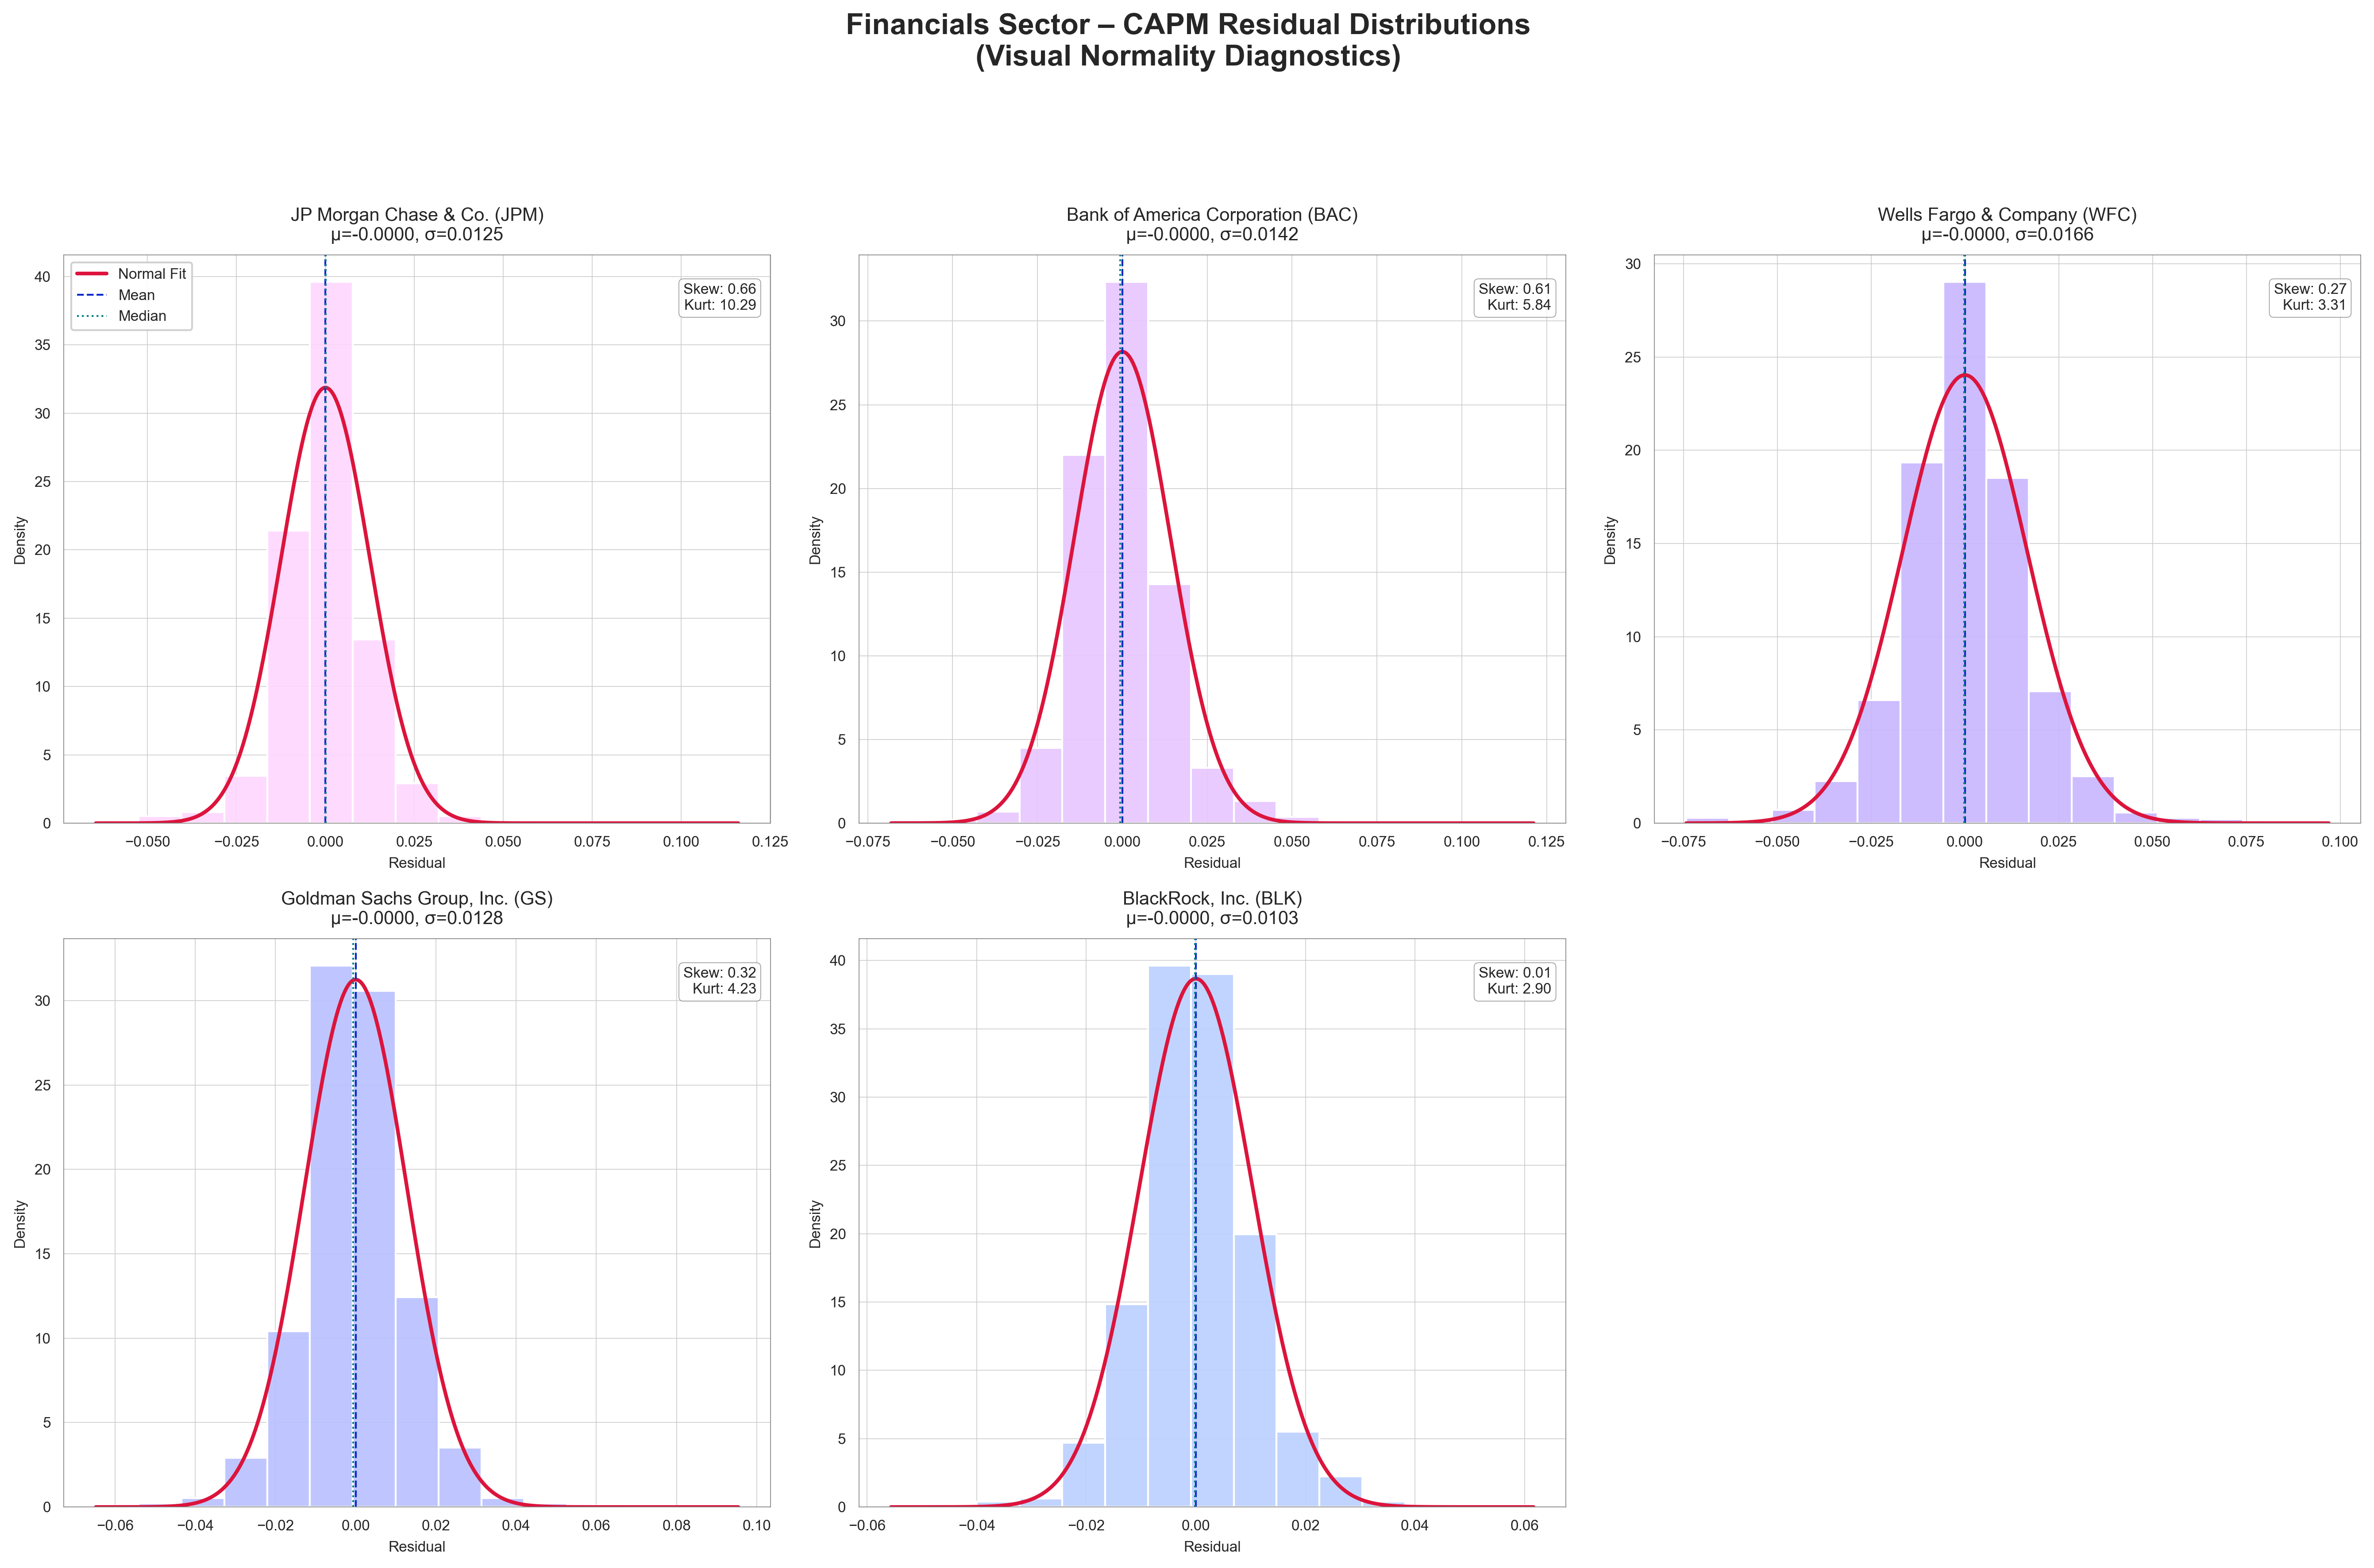

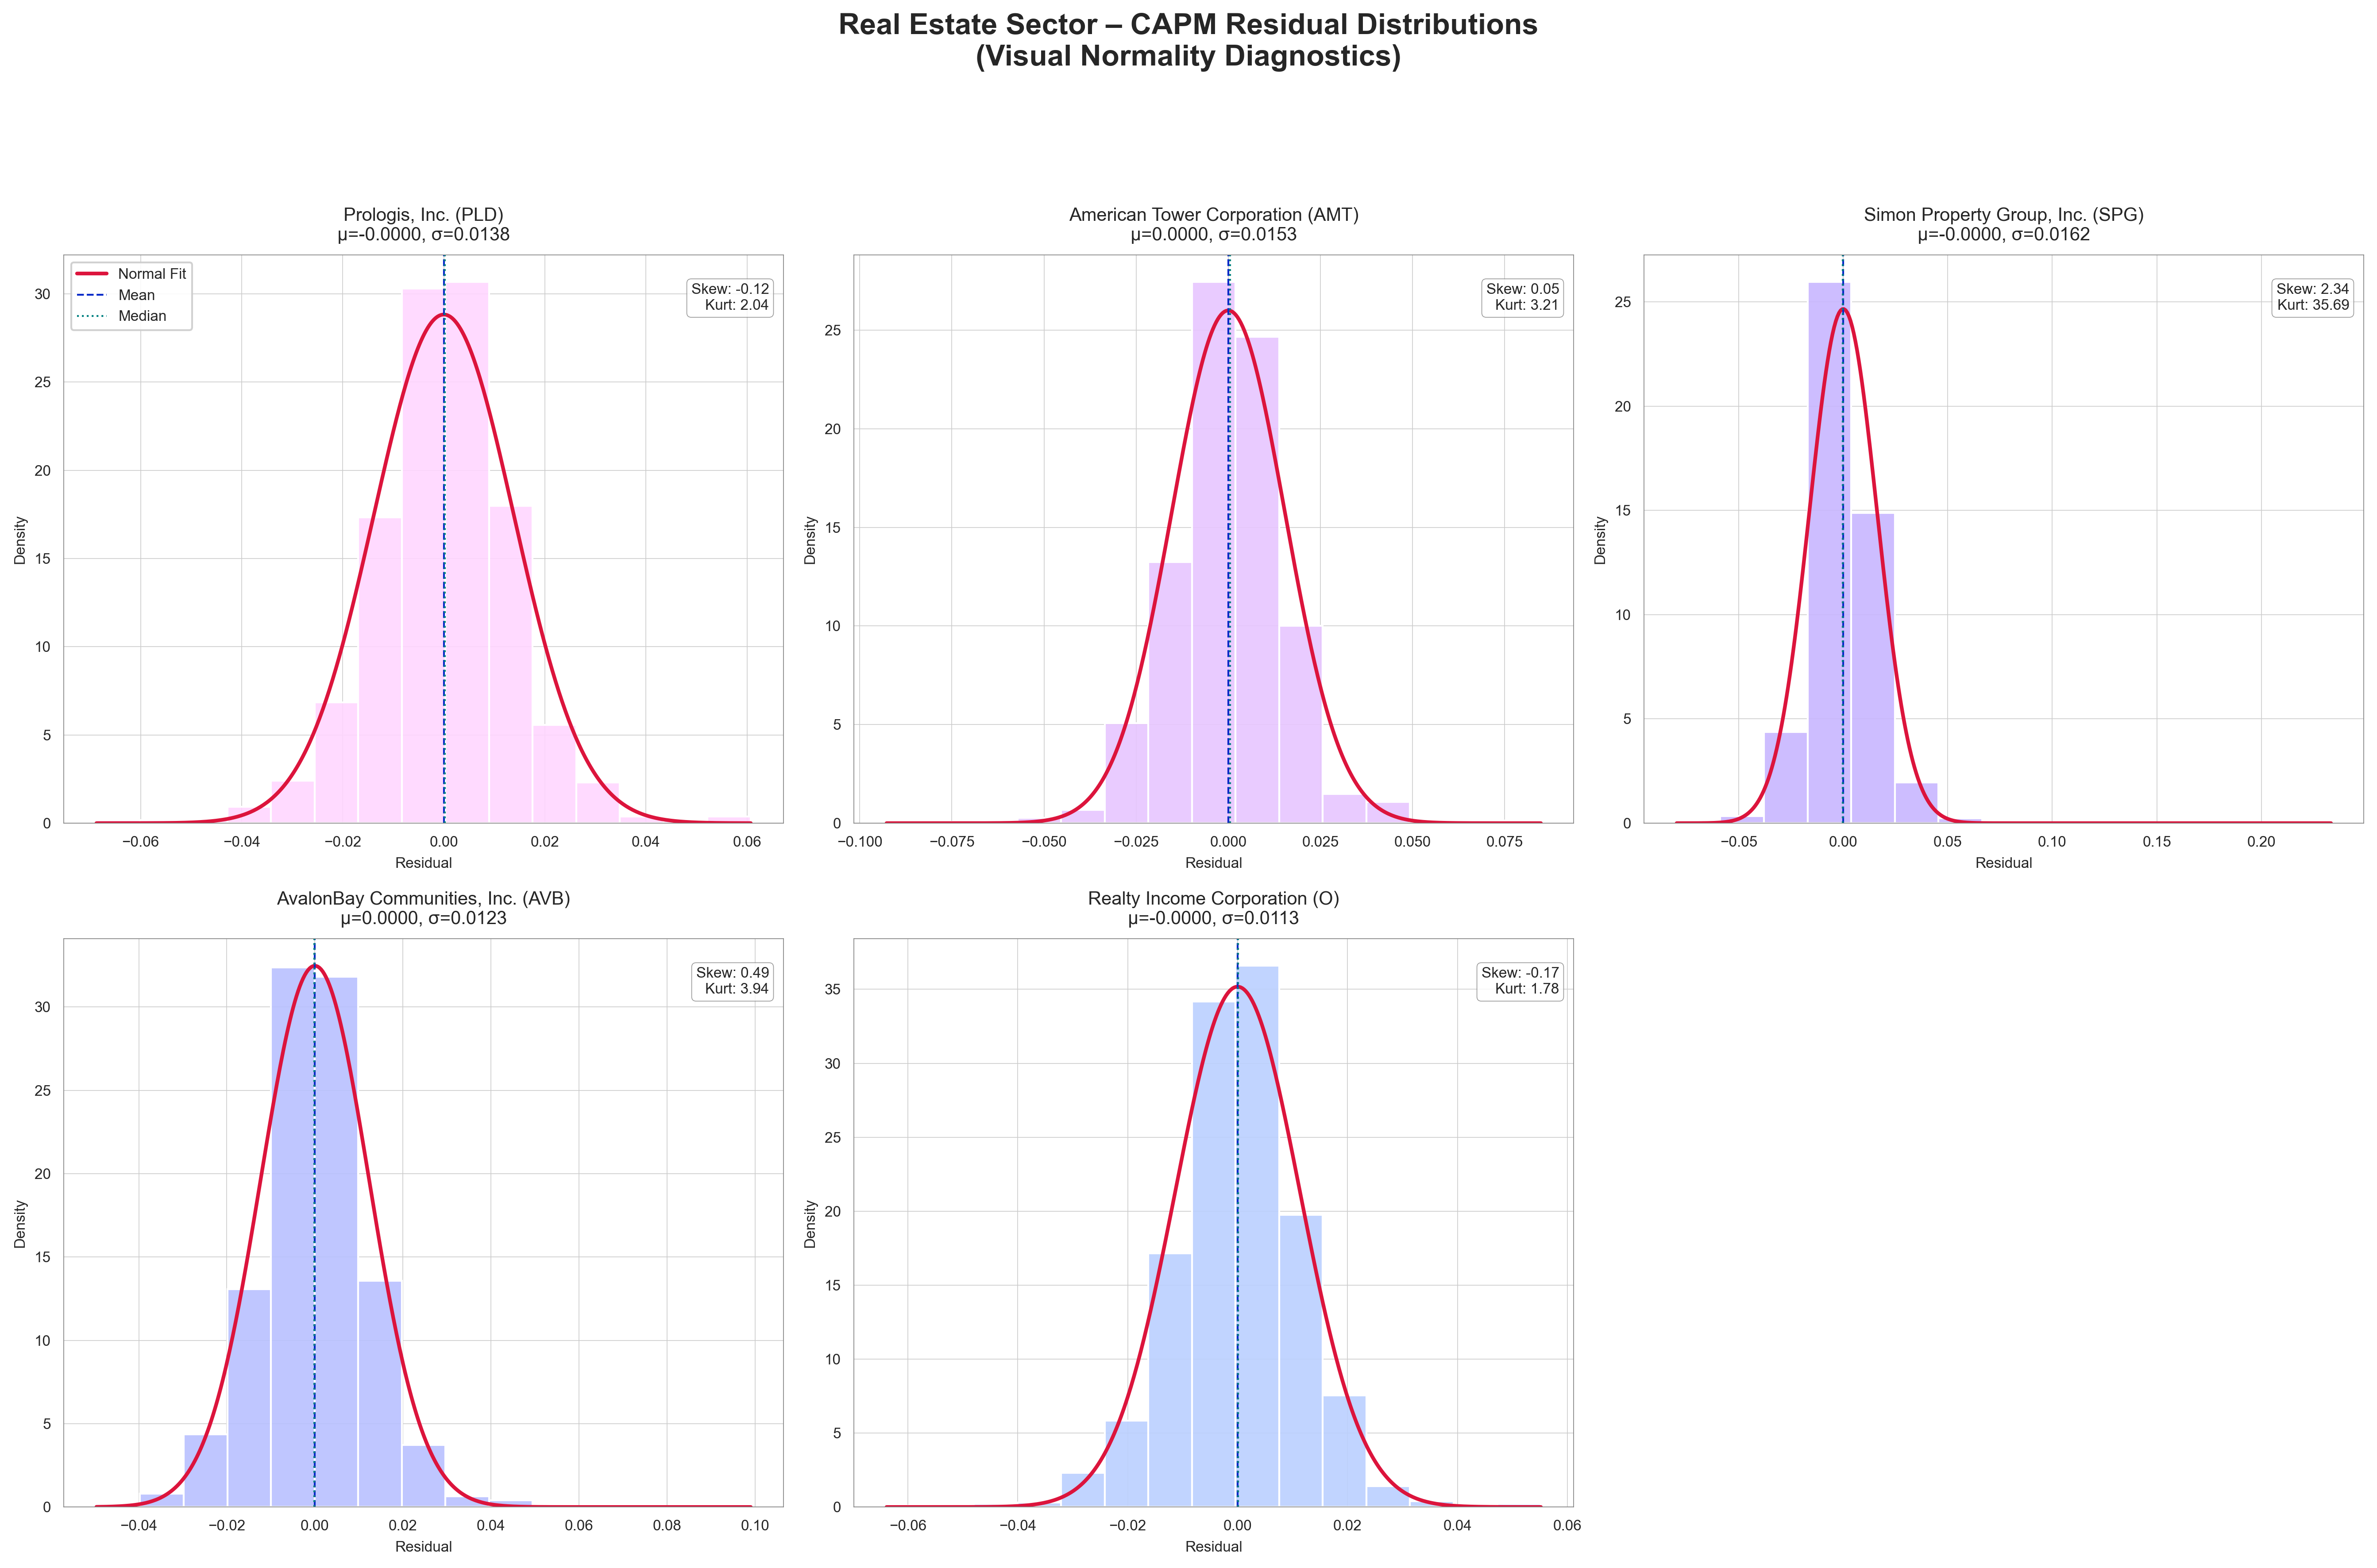

In [22]:
# 9.1.1 Residual Histograms – Visual Normality Check (by sector, 3 per row)

# Sector definitions (from user)
financials = {
    'JPM': 'JP Morgan Chase & Co. (JPM)',
    'BAC': 'Bank of America Corporation (BAC)',
    'WFC': 'Wells Fargo & Company (WFC)',
    'GS':  'Goldman Sachs Group, Inc. (GS)',
    'BLK': 'BlackRock, Inc. (BLK)'
}

real_estate = {
    'PLD': 'Prologis, Inc. (PLD)',
    'AMT': 'American Tower Corporation (AMT)',
    'SPG': 'Simon Property Group, Inc. (SPG)',
    'AVB': 'AvalonBay Communities, Inc. (AVB)',
    'O':   'Realty Income Corporation (O)'
}

pastel_colors = ['#FFD6FF', '#E7C6FF', '#C8B6FF', '#B8C0FF', '#BBD0FF', '#C0E0FF']

sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.grid": True,
    "grid.linewidth": 0.4,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 10,
    "legend.fontsize": 8,
    "figure.dpi": 300
})


def plot_residual_histograms(sector_dict, sector_name):

    tickers = list(sector_dict.keys())
    names = list(sector_dict.values())
    
    N = len(tickers)
    rows = int(np.ceil(N / 3))

    fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axes = axes.flatten()

    for i, (t, title) in enumerate(zip(tickers, names)):

        ax = axes[i]
        col = f"residual_{t}"
        data = residuals_df[col].dropna()
        color = pastel_colors[i % len(pastel_colors)]

        # Histogram (bins reduced to 15 to match screenshot)
        sns.histplot(
            data, bins=15, stat='density',
            color=color, edgecolor='white',
            alpha=0.9, ax=ax
        )

        # Normal curve – using full range like screenshot
        mu, sigma = data.mean(), data.std()
        x_min, x_max = data.min(), data.max()
        x = np.linspace(x_min, x_max, 400)
        y = norm.pdf(x, mu, sigma)

        ax.plot(x, y, color='crimson', lw=2.0, label='Normal Fit')

        # Mean + Median
        ax.axvline(mu, color='#072AC8', linestyle='--', lw=1.0, label='Mean')
        ax.axvline(data.median(), color='teal', linestyle=':', lw=1.0, label='Median')

        # Skewness + Kurtosis Box
        ax.text(
            0.98, 0.95,
            f"Skew: {skew(data):.2f}\nKurt: {kurtosis(data):.2f}",
            transform=ax.transAxes,
            fontsize=8, ha='right', va='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.4, alpha=0.8)
        )

        ax.set_title(f"{title}\nμ={mu:.4f}, σ={sigma:.4f}", pad=8)
        ax.set_xlabel("Residual")
        ax.set_ylabel("Density")

        # Thin border
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.4)
            spine.set_color("gray")

        if i == 0:
            ax.legend(loc='upper left', frameon=True, framealpha=0.9)

    # Remove empty axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(
        f"{sector_name} Sector – CAPM Residual Distributions\n(Visual Normality Diagnostics)",
        fontsize=16, fontweight='bold'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# Generate:
plot_residual_histograms(financials, "Financials")
plot_residual_histograms(real_estate, "Real Estate")

##### 9.2 Test Normality of Residuals (Jarque-Bera)

$H_0:$ Residuals are normally distributed (i.e., skewness = 0 and kurtosis = 3)  
$H_1:$ Residuals are not normally distributed

In [26]:
# 9.2 Jarque-Bera Test for Normality of Residuals
jb_results = {}

# Extract tickers from results_dict to ensure consistent ordering
tickers = list(results_dict.keys())

for t in tickers:
    col = f"residual_{t}"
    resid = residuals_df[col].dropna().values
    
    jb_stat, jb_p = jarque_bera(resid)
    
    jb_results[t] = {
        "JB_stat": jb_stat,
        "JB_pvalue": f"{jb_p:.3e}",
        "Reject_H0_5%": "Yes" if jb_p < 0.05 else "No",
    }

# preview
pd.DataFrame(jb_results).T

,JB_stat,JB_pvalue,Reject_H0_5%
JPM,5603.819605,0.000e+00,Yes
BAC,1855.184738,0.000e+00,Yes
WFC,585.388575,7.665e-128,Yes
GS,953.469522,9.052e-208,Yes
BLK,438.013909,7.700e-96,Yes
PLD,218.649493,3.318e-48,Yes
AMT,536.024476,4.016e-117,Yes
SPG,67472.074005,0.000e+00,Yes
AVB,856.974597,8.134e-187,Yes
O,171.058814,7.162e-38,Yes


##### 9.3 Test Heteroskedasticity (Breusch-Pagan)

$H_0:$ Homoskedasticity (constant variance of residuals)  
$H_1:$ Heteroskedasticity (non-constant variance of residuals)

In [27]:
bp_results = {}

tickers = list(results_dict.keys())

for t in tickers:
    model = results_dict[t]
    
    # BP test inputs
    resid = model.resid
    exog = model.model.exog
    
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(resid, exog)
    
    bp_results[t] = {
        "BP_stat": bp_stat,
        "BP_pvalue": bp_pvalue,
        "Reject_H0_5%": "Yes" if bp_pvalue < 0.05 else "No",
    }

# preview
pd.DataFrame(bp_results).T

,BP_stat,BP_pvalue,Reject_H0_5%
JPM,0.946548,0.330599,No
BAC,0.629115,0.42768,No
WFC,0.477419,0.489594,No
GS,0.04792,0.826723,No
BLK,1.397756,0.2371,No
PLD,7.246043,0.007106,Yes
AMT,0.210507,0.646371,No
SPG,0.801432,0.370666,No
AVB,1.23077,0.267257,No
O,0.121972,0.726905,No


##### 9.4 Test Autocorrelation (Durbin-Watson)

In [31]:
dw_results = {}

tickers = list(results_dict.keys())

for t in tickers:
    model = results_dict[t]
    dw_stat = durbin_watson(model.resid)

    # interpret DW statistic
    if dw_stat < 1.63:
        interp = "Positive autocorrelation"
    elif dw_stat > 1.72:
        interp = "No autocorrelation"
    else:
        interp = "Inconclusive"

    dw_results[t] = {
        "DW_stat": dw_stat,
        "dw_stat < 1.63": "Yes" if dw_stat < 1.63 else "No",
        "dw_stat > 1.72": "Yes" if dw_stat > 1.72 else "No",
        "Interpretation": interp
    }

pd.DataFrame(dw_results).T

,DW_stat,dw_stat < 1.63,dw_stat > 1.72,Interpretation
JPM,2.066531,No,Yes,No autocorrelation
BAC,1.923381,No,Yes,No autocorrelation
WFC,2.037119,No,Yes,No autocorrelation
GS,1.997781,No,Yes,No autocorrelation
BLK,2.011396,No,Yes,No autocorrelation
PLD,2.085813,No,Yes,No autocorrelation
AMT,1.937982,No,Yes,No autocorrelation
SPG,2.079305,No,Yes,No autocorrelation
AVB,2.088127,No,Yes,No autocorrelation
O,1.985196,No,Yes,No autocorrelation


##### 9.5 Test Autocorrelation (Breusch-Godfrey)

$H_0:$ No autocorrelation up to the first lag order.  
$H_1:$ Autocorrelation exists up to the first lag order.

In [32]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

bg_results = {}

tickers = list(results_dict.keys())

for t in tickers:
    model = results_dict[t]

    # Breusch–Godfrey test for first-order autocorrelation
    lm_stat, lm_pvalue, f_stat, f_pvalue = acorr_breusch_godfrey(model, nlags=1)

    # Interpretation
    if lm_pvalue < 0.05:
        interp = "Autocorrelation detected"
    else:
        interp = "No autocorrelation"

    bg_results[t] = {
        "LM_stat": lm_stat,
        "LM_pvalue": lm_pvalue,
        "F_stat": f_stat,
        "F_pvalue": f_pvalue,
        "Interpretation (5%)": interp
    }

pd.DataFrame(bg_results).T
 

,LM_stat,LM_pvalue,F_stat,F_pvalue,Interpretation (5%)
JPM,1.463436,0.226384,1.461635,0.226899,No autocorrelation
BAC,1.690503,0.193535,1.68873,0.194009,No autocorrelation
WFC,0.543783,0.460869,0.542714,0.461449,No autocorrelation
GS,0.00128,0.971464,0.001277,0.971504,No autocorrelation
BLK,0.058402,0.809039,0.058265,0.8093,No autocorrelation
PLD,2.415914,0.120108,2.414783,0.120448,No autocorrelation
AMT,1.200246,0.273273,1.198516,0.27383,No autocorrelation
SPG,2.212961,0.136856,2.211566,0.137232,No autocorrelation
AVB,2.608101,0.106319,2.607281,0.106627,No autocorrelation
O,0.049465,0.823996,0.049349,0.824237,No autocorrelation
